### Augmentation Visualizations

This notebook provides a visual exploration of the data augmentation techniques employed:  RandAugment and CutMix.

##### Import Libraries and Packages

In [10]:
from PIL import Image
import numpy as np
import io
import boto3
import re
import os
import seaborn as sns
import random
from pathlib import Path
from glob import glob
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

pd.set_option('display.max_rows', 500)

##### Import Data

In [2]:
bucket = 'sagemaker-june29'
s3path_ra = 'sagemaker/RandAugmentation/'
s3path_cm = 'sagemaker/CutMix/'

In [3]:
def download_ra_datasets(s3bucket, s3path, file):
    label_filename = s3path + 'cifar10_labels.npy'
    image_filename = s3path + file 
    
    s3 = boto3.resource('s3')
    obj = s3.Object(s3bucket, label_filename)
    with io.BytesIO(obj.get()["Body"].read()) as f:
        f.seek(0)
        labels = np.load(f)
        y = labels.astype('long')
            
    obj = s3.Object(s3bucket, image_filename)
    with io.BytesIO(obj.get()["Body"].read()) as f:
        f.seek(0)
        X = np.load(f)
        
    return X,y

d_2x5, l_2x5 = download_ra_datasets(bucket, s3path_ra, 'cifar10_ra_2_5.npy')
d_2x20, l_2x20 = download_ra_datasets(bucket, s3path_ra, 'cifar10_ra_2_20.npy')
d_3x20, l_3x20 = download_ra_datasets(bucket, s3path_ra, 'cifar10_ra_3_20.npy')

In [11]:
def download_cm_datasets(s3bucket, s3path, file):
    label_filename = s3path + file + '_labels.npy'
    image_filename = s3path + file + '_data.pt'
    
    s3 = boto3.resource('s3')
    obj = s3.Object(s3bucket, label_filename)
    with io.BytesIO(obj.get()["Body"].read()) as f:
        f.seek(0)
        y = np.load(f)

    obj = s3.Object(s3bucket, image_filename)
    with io.BytesIO(obj.get()["Body"].read()) as f:
        f.seek(0)
        x = torch.load(f)
        x = [torch.squeeze(item) for item in x]
        x = [transforms.ToPILImage()(item) for item in x]
        X = [np.array(item) for item in x]

    return X, y

d_cm_1, l_cm_1 = download_cm_datasets(bucket, s3path_cm, 'cifar10_cm_beta1_prob1')
d_cm_5, l_cm_5 = download_cm_datasets(bucket, s3path_cm, 'cifar10_cm_beta1_prob.5')
d_cm_25, l_cm_25 = download_cm_datasets(bucket, s3path_cm, 'cifar10_cm_beta1_prob.25')

##### Helper Functions to Display Images

In [15]:
# Create a dictionary that maps numeric class number to class name
class_dict = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
              5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
             }

# Function to print a list of images
def print_imgs(dataset, datalabels, img_indexes):
    images_to_print = []
    stats = []
    
    for ii in img_indexes:
        img_dict = {'correct_label': datalabels[ii],
                    #'correct_label_id': class_dict[datalabels[ii]],
                    'img_index': ii
                   }
        
        img=Image.fromarray(dataset[ii])
        images_to_print.append(img)
        
        #stats.append(class_dict[datalabels[ii]])
        stats.append(datalabels[ii])

    # Print the misclassified images
    wrong = len(img_indexes)
    last_row = [1 if wrong % 10 != 0 else 0]
    whole_rows = wrong // 10
    
    fig = plt.figure(figsize=(8 * (whole_rows + 1), 2 * (whole_rows + 1)))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(whole_rows + 1, 10),  
                     axes_pad=0.1,  
                     )

    for ax, im in zip(grid, images_to_print):
        # Iterating over the grid returns the Axes
        ax.imshow(im)
        
    print("Correct Labels by Row:")
    #print("\n".join([" ".join(stats[i:i+10]) for i in range(0,len(stats),10)]))

##### RandAugment Images

###### Unaugmented Data

Files already downloaded and verified
[3, 0, 1, 5, 6, 2, 9, 4, 8, 7]
Correct Labels by Row:


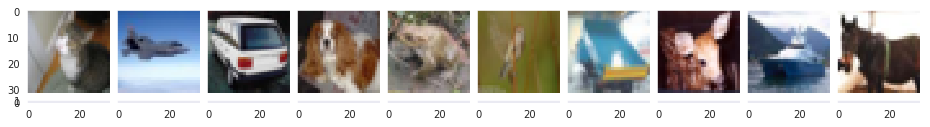

In [181]:
plt.rcParams["axes.grid"] = False
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
print([trainset.targets[i] for i in [101, 1601, 2200, 3107, 4403, 5111, 6016, 7100, 8006, 1054]])
print_imgs(trainset.data, trainset.targets, np.array([101, 1601, 2200, 3107, 4403, 5111, 6016, 7100, 8006, 1054]))

###### RandAugment, N=2, M=5
###### *Two Transformations, Magnitude of 5*

Correct Labels by Row:


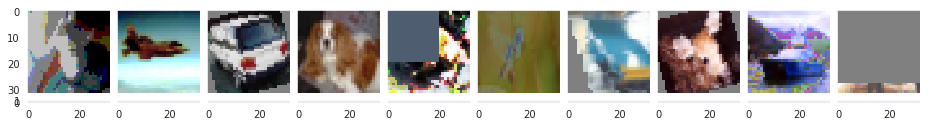

In [185]:
print_imgs(d_2x5, l_2x5, np.array([101, 1601, 2200, 3107, 4403, 5111, 6016, 7100, 8006, 1054]))

###### RandAugment, N=2, M=20
###### *Two Transformations, Magnitude of 20*

Correct Labels by Row:


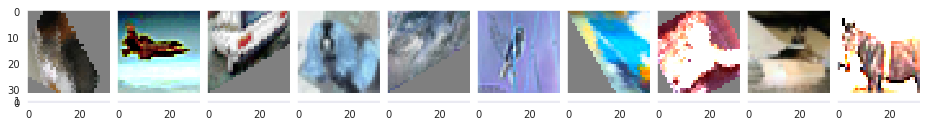

In [189]:
print_imgs(d_2x20, l_2x20, np.array([101, 1601, 2200, 3107, 4403, 5111, 6016, 7100, 8006, 1054]))

###### RandAugment, N=3, M=20
###### *Three Transformations, Magnitude of 20*

Correct Labels by Row:


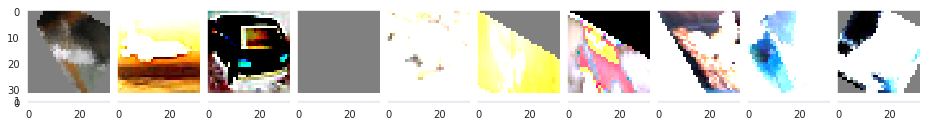

In [190]:
print_imgs(d_3x20, l_3x20, np.array([101, 1601, 2200, 3107, 4403, 5111, 6016, 7100, 8006, 1054]))

##### CutMix Images

Correct Labels by Row:


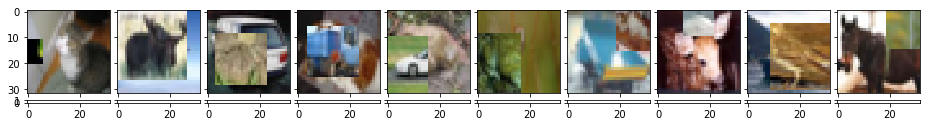

In [19]:
cmarray = np.array([101, 1601, 2200, 3107, 4403, 5111, 6016, 7100, 8006, 1054])
print_imgs(d_cm_1, l_cm_1, cmarray)

In [22]:
for i in cmarray:
    print(class_dict[int(l_cm_1[i][0])], class_dict[int(l_cm_1[i][1])])

cat frog
airplane deer
automobile frog
dog truck
frog automobile
bird frog
truck dog
deer horse
ship bird
horse bird


### Read in Results

In [3]:
search_path = "./"
file_extension = "*.csv"
os.chdir('/home/ec2-user/SageMaker/w210-capstone/original_model_results/')
dfs = []
[dfs.append(pd.read_csv(file, index_col=0))
 for path, subdir, files in os.walk(search_path)
 for file in glob(os.path.join(path, file_extension))]

df_orig = pd.concat(dfs, ignore_index=True)
#df_orig['Accuracy'] = df_orig['Accuracy'].apply(lambda x: x*100)
#df_orig['Original_CI'] = df_orig.Original_CI.apply(lambda x: literal_eval(x))
#df_orig['Orig_CI_Low'], df_orig['Orig_CI_Hi'] = zip(*df_orig.Original_CI)

# Filter data into subsets based on test dataset used
df_orig_cifar10 = df_orig[df_orig['Testset'] == 'cifar10']
df_orig_cifar101 = df_orig[df_orig['Testset'] == 'cifar10.1']

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [4]:
df_orig

,Accuracy,Epoch,Loss,Model,Original_Accuracy,Original_Accuracy_300epochs,Original_CI,Original_CI_300epochs,Testset
0,0.7900,400,1.1176,densenet_BC_100_12_ra_2_20,95.5,NaN,"(95.1, 95.9)",NaN,cifar10
1,0.7854,300,1.0739,densenet_BC_100_12_ra_2_20,95.5,NaN,"(95.1, 95.9)",NaN,cifar10
2,0.6390,400,2.0759,densenet_BC_100_12_ra_2_20,87.6,NaN,"(86.1, 89.0)",NaN,cifar10.1
3,0.6275,300,1.9997,densenet_BC_100_12_ra_2_20,87.6,NaN,"(86.1, 89.0)",NaN,cifar10.1
4,0.8290,50,0.6475,densenet_BC_100_12_ra_2_20_refined400,87.6,NaN,"(86.1, 89.0)",NaN,cifar10.1
5,0.9168,50,0.3217,densenet_BC_100_12_ra_2_20_refined400,95.5,NaN,"(95.1, 95.9)",NaN,cifar10
6,0.8857,400,0.3952,resnext_29_4x64d_ra_2_5,NaN,96.4,NaN,"(96.0, 96.7)",cifar10
7,0.7755,400,0.7954,resnext_29_4x64d_ra_2_5,NaN,89.6,NaN,"(88.2, 90.9)",cifar10.1
8,0.9354,50,0.2333,resnext_29_4x64d_ra_2_5_refined400,NaN,96.4,NaN,"(96.0, 96.7)",cifar10
9,0.8455,50,0.5154,resnext_29_4x64d_ra_2_5_refined400,NaN,89.6,NaN,"(88.2, 90.9)",cifar10.1


In [8]:
final_score_subset = df_orig[['Model', 'Accuracy', 'Testset']].sort_values(by=['Model'])

# Remove models that we did not run randaugment datasets through
final_score_subset = final_score_subset[~final_score_subset["Model"].str.contains('resnet_basic_44')]
final_score_subset = final_score_subset[~final_score_subset["Model"].str.contains('pyramidnet_basic_110_84')]
final_score_subset = final_score_subset[~final_score_subset["Model"].str.contains('resnext_29_8x64d')]


p2 = re.compile("([\d]+)(_refined)?(\d*)")

final_score_subset['ra'] = final_score_subset['Model'].str.contains("ra_")

def ra_N_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    N=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Model'].lower())
        N = int(srch3.group(1))
    return N

def ra_M_extraction(row):
    p3 = re.compile("ra_(\d+)_(\d+)")
    M=0 
    if row['ra'] == True :
        srch3 = p3.search(row['Model'].lower())
        M = int(srch3.group(2))
    return M

final_score_subset['N'] = final_score_subset.apply(lambda row: ra_N_extraction(row), axis=1)
final_score_subset['M'] = final_score_subset.apply(lambda row: ra_M_extraction(row), axis=1)
cols = ['N', 'M']
final_score_subset['hue'] = final_score_subset[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


#final_score_subset[final_score_subset['Model'].str.contains("refined300")]
final_score_subset

,Model,Accuracy,Testset,ra,N,M,hue
56,densenet_BC_100_12,0.9456,cifar10,False,0,0,0_0
58,densenet_BC_100_12,0.8830,cifar10.1,False,0,0,0_0
57,densenet_BC_100_12,0.9484,cifar10,False,0,0,0_0
55,densenet_BC_100_12,0.8875,cifar10,False,0,0,0_0
0,densenet_BC_100_12_ra_2_20,0.7900,cifar10,True,2,20,2_20
1,densenet_BC_100_12_ra_2_20,0.7854,cifar10,True,2,20,2_20
2,densenet_BC_100_12_ra_2_20,0.6390,cifar10.1,True,2,20,2_20
3,densenet_BC_100_12_ra_2_20,0.6275,cifar10.1,True,2,20,2_20
62,densenet_BC_100_12_ra_2_20_c10val,0.6745,cifar10.1,True,2,20,2_20
61,densenet_BC_100_12_ra_2_20_c10val,0.6815,cifar10.1,True,2,20,2_20


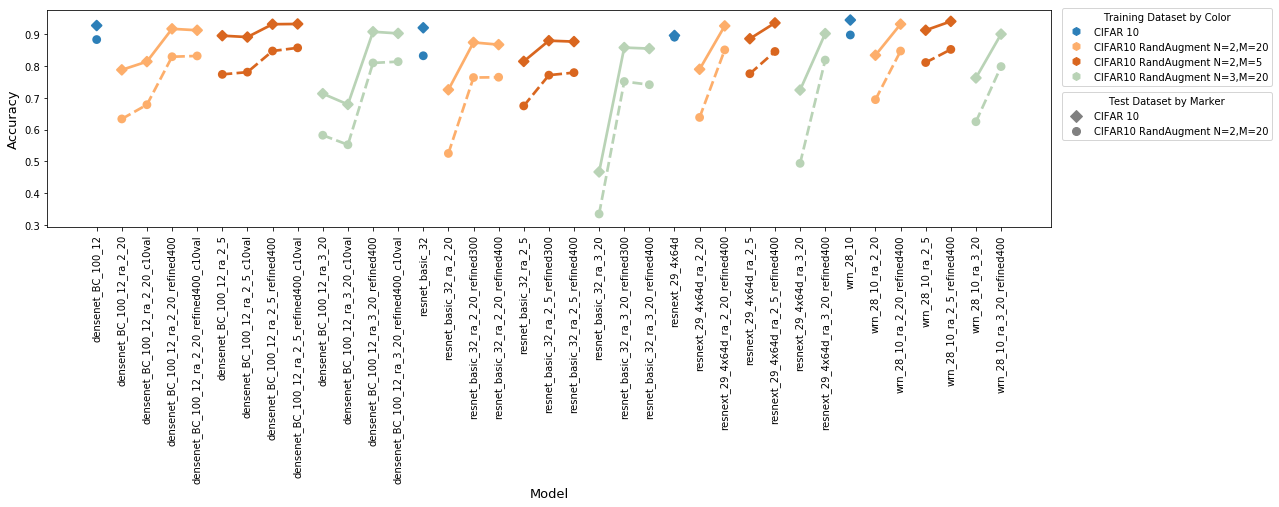

In [9]:
flatui = ["#2c7fb8", "#fdae6b", "#D9661F", "#B9D3B6", "#B9D3B6", "#859438"]
#sns.palplot(sns.color_palette(flatui))


f, ax = plt.subplots(figsize=(18, 4))
sp = sns.pointplot(x="Model", hue="hue", y="Accuracy", data=final_score_subset[final_score_subset['Testset'] == 'cifar10'], 
                   markers=['D'] * 4, linestyles=['-']*4, palette=flatui, ci=None)  
plt.xlabel('Model', fontsize=13)
plt.ylabel('Accuracy', fontsize=13)
#plt.title("Model Accuracy", fontsize=16)
plt.setp(ax.get_xticklabels(), rotation=90)
sns.set_style()

sp = sns.pointplot(x="Model", hue="hue", y="Accuracy", data=final_score_subset[final_score_subset['Testset'] == 'cifar10.1'], 
                   markers=['o']*4, linestyles=['--']*4, palette=flatui, ci=None,alpha=0.7) # and slightly transparent

#[0, 1, 2, 3, 4, u'D', 6, 7, 8, u's', u'|', 11, u'None', u'P', 9, u'x', u'X', 5, u'_', u'^', u' ', 
# None, u'd', u'h', u'+', u'*', u',', u'o', u'.', u'1', u'p', u'3', u'2', u'4', u'H', u'v', u'', u'8', 10, u'&lt;', u'&gt;']

# leg_handles = ax.get_legend_handles_labels()[0]
train_datasets = ['CIFAR 10', 'CIFAR10 RandAugment N=2,M=20', 'CIFAR10 RandAugment N=2,M=5', 'CIFAR10 RandAugment N=3,M=20']
test_datasets = ['CIFAR 10', 'CIFAR 10.1']
# ax.legend(leg_handles, title='Training Dataset')

h = [plt.plot([],[], color=c, marker="h", ms=8, ls="")[0] for i,c in zip(train_datasets, flatui)]
leg = ax.legend(handles=h, labels=train_datasets,loc=(1.01,0.65), title="Training Dataset by Color")
ax.add_artist(leg)

h2 = [plt.plot([],[], color='grey', marker=m, ms=8, ls="")[0] for i,m in zip(test_datasets, ['D', 'o'])]
ax.legend(handles=h2, labels=train_datasets,loc=(1.01,0.4), title="Test Dataset by Marker")


os.chdir('/home/ec2-user/SageMaker/')
plt.savefig('error-by-token-type.png')

pass

In [86]:
ax

In [87]:
leg_handles[0]

In [89]:
leg_handles[1]

['0_0', '2_20', '2_5', '3_20', '0_0', '2_20', '2_5', '3_20']

### Read in Predictions

In [60]:
to_be_101_df = []
to_be_10_df = []

p1 = re.compile("predictions_(.+?)(_cifar101){0,1}.npz")
p2 = re.compile("([\d]+)(_refined)?(\d*)")
p3 = re.compile("ra_(\d+)_(\d+)")

os.chdir('/home/ec2-user/SageMaker/w210-capstone/original_model_results/')
for path in Path('./').rglob('*.npz'):
    model = str(path.parent)
    srch1 = p1.search((path.name).lower())
    g1 = srch1.group(1)
    epochs, refined_epochs = 0, 0
    N, M = 0, 0 
    
    if 'refined' in g1:
        epochs = 400
        srch2 = p2.search(g1, re.IGNORECASE)
        if srch2.group(2) != None:
#             print("__group1:", srch2.group(1))
#             print("__group2:", srch2.group(2))
#             print("__group3:", srch2.group(3))
#            epochs = srch2.group(1)
            refined_epochs = srch2.group(3)
        else:
#             print(" ELSE:")
#             print("__group1:", srch2.group(1))
#             print("__group2:", srch2.group(2))
#             print("__group3:", srch2.group(3))
#             print(" __ epochs = 400")
            refined_epochs = srch2.group(1)

    else:
        epochs = g1   
    
    testset = 'cifar101' in (path.name).lower()
    rand_aug = "ra_" in str(path.parent).lower()
    refined = "refined" in (path.name).lower()
    npzf = np.load(path)
    
    if rand_aug:
        srch3 = p3.search(model.lower())
        N = int(srch3.group(1))
        M = int(srch3.group(2))
        
    if testset:
        # Remove if statement once correct file is checked in for this dataset
        if str(path) not in 'resnet_basic_32_ra_2_20/predictions_400_CIFAR101.npz':
            result_by_img = test_labels_CIFAR101 == npzf['labels']
            to_be_101_df.append([model,testset,rand_aug,int(epochs),int(refined_epochs), N, M]
                                + result_by_img.tolist())
    else:
        result_by_img = test_labels_CIFAR10 == npzf['labels']
        to_be_10_df.append([model,testset,rand_aug,int(epochs),int(refined_epochs), N, M] 
                           + result_by_img.tolist())
        
        
results_cifar101 = pd.DataFrame(to_be_101_df) 
results_cifar101.rename(columns=lambda x: 'img' + str(x-7), inplace=True)
results_cifar101.rename(columns = {'img-7':"model", 'img-6':"cifar101", 'img-5':"randaug",
                                   'img-4':"epochs", 'img-3':"refined_epochs",
                                   'img-2':"N", 'img-1':"M"
                                  }, inplace=True)

results_cifar10 = pd.DataFrame(to_be_10_df) 
results_cifar10.rename(columns=lambda x: 'img' + str(x-7), inplace=True)
results_cifar10.rename(columns = {'img-7':"model", 'img-6':"cifar101", 'img-5':"randaug",
                                  'img-4':"epochs", 'img-3':"refined_epochs",
                                  'img-2':"N", 'img-1':"M"
                                 }, inplace=True)



NameError: name 'p3' is not defined